## Beyond the Model: Data Ethics

**Goals:**

- Prepare a household dataset for binary classification.

- Create a logistic regression model to predict severe damage.

- Explain model prediction using odds ratio.

- Interrogate importance features based on caste.

In [1]:
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

### Prepare Data

Import data from sqlite server

In [25]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
            SELECT h.*,
            s.*,
            i.vdcmun_id,
            d.damage_grade
        FROM household_demographics AS h
        JOIN id_map AS i ON i.household_id = h.household_id
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage as d ON i.building_id = d.building_id
        WHERE district_id = 4
        """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="household_id")

    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")

    # Group caste column
    top_10=df["caste_household"].value_counts(10).index
    df["caste_household"]=df["caste_household"].apply(
        lambda c: c if c in top_10 else "other"
        )
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

Importing from local dir:

In [44]:
df = pd.read_csv("data/household_df.csv", index_col="household_id")
df.head()

,gender_household_head,age_household_head,caste_household,education_level_household_head,income_level_household,size_household,is_bank_account_present_in_household,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,vdcmun_id,severe_damage
household_id,,,,,,,,,,,,,,,,,,,,
16400201,Female,46,Chhetree,Class 5,Rs. 10-20 thousand,4,1,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408101,Male,66,Chhetree,Illiterate,Rs. 10 thousand,5,0,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16408901,Male,54,Magar,Class 4,Rs. 10 thousand,5,1,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16409801,Male,36,Chhetree,Class 5,Rs. 10 thousand,6,1,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0
16410301,Female,39,Chhetree,Class 4,Rs. 10 thousand,3,0,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",38,0


High-Cardinality Features

In [45]:
df.select_dtypes("object").nunique()

gender_household_head              2
caste_household                   63
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

In [46]:
df["caste_household"].value_counts().head()

caste_household
Gurung          15119
Brahman-Hill    13043
Chhetree         8766
Magar            8180
Sarki            6052
Name: count, dtype: int64

In [47]:
df["caste_household"].value_counts().tail()

caste_household
Byasi/Sauka    1
Kalar          1
Dhimal         1
Kalwar         1
Hyolmo         1
Name: count, dtype: int64

Next: Take the top 10 ethnicities, and group the rest as others.

In [48]:
df["caste_household"].value_counts().head(10)

caste_household
Gurung          15119
Brahman-Hill    13043
Chhetree         8766
Magar            8180
Sarki            6052
Newar            5906
Kami             3565
Tamang           2396
Kumal            2271
Damai/Dholi      1977
Name: count, dtype: int64

In [49]:
top_10=df["caste_household"].value_counts().head(10).index
top_10

Index(['Gurung', 'Brahman-Hill', 'Chhetree', 'Magar', 'Sarki', 'Newar', 'Kami',
       'Tamang', 'Kumal', 'Damai/Dholi'],
      dtype='object', name='caste_household')

In [50]:
df["caste_household"].apply(lambda c: c if c in top_10 else "other")#.value_counts()

household_id
16400201    Chhetree
16408101    Chhetree
16408901       Magar
16409801    Chhetree
16410301    Chhetree
              ...   
23477401       other
23480801       other
23482101       other
23482801       other
23483501       other
Name: caste_household, Length: 75883, dtype: object

In [51]:
df["caste_household"].apply(lambda c: c if c in top_10 else "other").value_counts()

caste_household
Gurung          15119
Brahman-Hill    13043
Chhetree         8766
other            8608
Magar            8180
Sarki            6052
Newar            5906
Kami             3565
Tamang           2396
Kumal            2271
Damai/Dholi      1977
Name: count, dtype: int64

In [52]:
df["caste_household"]=df["caste_household"].apply(lambda c: c if c in top_10 else "other")

In [53]:
df.select_dtypes("object").nunique()

gender_household_head              2
caste_household                   11
education_level_household_head    19
income_level_household             5
land_surface_condition             3
foundation_type                    5
roof_type                          3
ground_floor_type                  5
other_floor_type                   4
position                           4
plan_configuration                10
superstructure                    11
dtype: int64

In [54]:
# Assertion
assert (
    df["caste_household"].nunique() == 11
), f"The `'caste_household'` column should only have 11 unique values, not {df['caste_household'].nunique()}."

### Split

In [55]:
df.shape

(75883, 20)

In [56]:
target = "severe_damage"
X = df.drop(columns=[target,"vdcmun_id"])
y = df[target]

In [58]:
# Assertion
assert X.shape == (75883, 18), f"The shape of `X` should be (75883, 18), not {X.shape}."
assert "vdcmun_id" not in X.columns, "There should be no `'vdcmun_id'` column in `X`."
assert y.shape == (75883,), f"The shape of `y` should be (75883,), not {y.shape}."

Train-test split

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=.2)

In [60]:
# Assertion
assert X_train.shape == (
    60706,
    18,
), f"The shape of `X_train` should be (60706, 18), not {X_train.shape}."
assert y_train.shape == (
    60706,
), f"The shape of `y_train` should be (60706,), not {y_train.shape}."
assert X_test.shape == (
    15177,
    18,
), f"The shape of `X_test` should be (15177, 18), not {X_test.shape}."
assert y_test.shape == (
    15177,
), f"The shape of `y_test` should be (15177,), not {y_test.shape}."

### Build Model

In [61]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.63


Iterate: Losgitic Regression

In [66]:
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=10000)
)
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['gender_household_head', 'caste_household',
                                     'education_level_household_head',
                                     'income_level_household',
                                     'land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=10000))])

#### Evaluate

The training and test accuracy scores for model_lr:

In [67]:
acc_train = accuracy_score(y_train, model_lr.predict(X_train))
acc_test = model_lr.score(X_test, y_test)

print("LR Training Accuracy:", acc_train)
print("LR Validation Accuracy:", acc_test)

LR Training Accuracy: 0.718330972226798
LR Validation Accuracy: 0.7219476839955196


### Communicate Results

Odds Ratio DataFrame

In [80]:
features = model_lr.named_steps["onehotencoder"].get_feature_names()
importances = model_lr.named_steps["logisticregression"].coef_[0]
feat_imp = pd.Series(np.exp(importances), index=features).sort_values()
feat_imp.head()

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\category_encoders\utils.py:366: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


superstructure_Other                   0.205928
superstructure_RC, engineered          0.317509
foundation_type_RC                     0.364037
roof_type_RCC/RB/RBC                   0.427226
superstructure_Brick, cement mortar    0.430194
dtype: float64

Odds Ratio Bar Chart

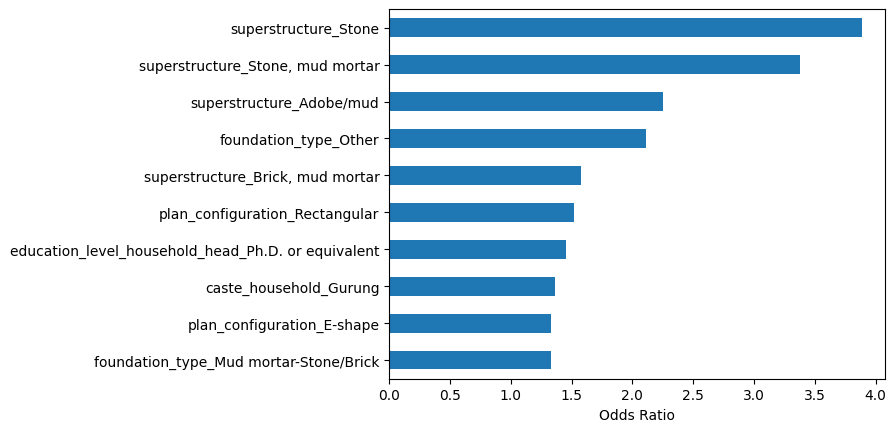

In [81]:
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Odds Ratio");

- Supper with stone increases the chances of a building suffering a severe damage.

- The model considers caste of household as a predictor for whether a building will suffer a severe damage or not.